In [2]:
import shutil

# Specify the folder path
folder_path = ''

# Remove the folder and its contents
shutil.rmtree(folder_path)

In [1]:
# import kaggle module
!pip install kaggle
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d 'sbaghbidi/human-faces-object-detection'

Dataset URL: https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection
License(s): unknown
 98%|████████████████████████████████████████▎| 490M/498M [00:03<00:00, 187MB/s]
100%|█████████████████████████████████████████| 498M/498M [00:03<00:00, 141MB/s]


In [ ]:
! unzip 'human-faces-object-detection.zip'

In [4]:
import pandas as pd
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import yaml
from ultralytics import YOLO

In [5]:
# Convert csv file into yolo format of annotations
def convert_csv_to_yolo(csv_file, image_folder, output_folder):

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    df = pd.read_csv(csv_file)
    for _, row in df.iterrows():
        image_name = row['image_name']
        width = row['width']
        height = row['height']
        x0 = row['x0']
        y0 = row['y0']
        x1 = row['x1']
        y1 = row['y1']

        x_center = (x0 + x1) / (2 * width)
        y_center = (y0 + y1) / (2 * height)
        bbox_width = (x1 - x0) / width
        bbox_height = (y1 - y0) / height

        yolo_annotation = f"0 {x_center} {y_center} {bbox_width} {bbox_height}\n"

        annotation_file = os.path.join(output_folder, image_name.replace('.jpg', '.txt'))
        with open(annotation_file, 'w') as f:
            f.write(yolo_annotation)

# Call the function
convert_csv_to_yolo('faces.csv',
                    'images',
                    'annotations')

In [6]:
def split_data(image_folder, annotation_folder, output_folder, train_size=0.85, val_size=0.15):
    # Ensure output directories exist
    os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'val'), exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    # Split the data
    train_files, val_files = train_test_split(image_files, test_size=val_size, random_state=21)

    # Move files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(output_folder, 'train', file))
        shutil.copy(os.path.join(annotation_folder, file.replace('.jpg', '.txt')), os.path.join(output_folder, 'train', file.replace('.jpg', '.txt')))

    for file in val_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(output_folder, 'val', file))
        shutil.copy(os.path.join(annotation_folder, file.replace('.jpg', '.txt')), os.path.join(output_folder, 'val', file.replace('.jpg', '.txt')))

# Call the function
split_data('images',
           'annotations',
           'output')

In [7]:
data = {
    'train': '/teamspace/studios/this_studio/output/train',
    'val': '/teamspace/studios/this_studio/output/val',
    'nc': 1,
    'names': ['face']
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file)

In [8]:
# Pretrained weights selection
pretrained_weights = {
    'yolov8': 'yolov8n.pt',
    'yolov9': 'yolov9c.pt',
    'yolov10': 'yolov10n.pt',
    'yolov11': 'yolo11n.pt'
}

In [9]:
def train_model(model_name, task, data_path, epochs=40, imgsz=640):
    
    # Model initialization
    model = YOLO(pretrained_weights[model_name])
    
    # Training
    results = model.train(
        data=data_path,
        epochs=epochs,
        imgsz=imgsz,
        task=task,
        batch=16,
        name=f'{model_name}_{task}'
    )
    
    return model, results

In [10]:
# Models and tasks to train
models_to_train = ['yolov8', 'yolov9', 'yolov10', 'yolov11']

# Store trained models and results
trained_models = {}

In [11]:
# Training loop
for model_name in models_to_train:
    print(f"Training {model_name}")
    
    model, results = train_model(model_name, task='detect', data_path='/teamspace/studios/this_studio/data.yaml')
    metrics = model.val()
    
    # Store model and results
    trained_models[model_name] = {
        'model': model,
        'results': results,
        'metrics': metrics
    }

Training yolov8


100%|██████████| 6.25M/6.25M [00:00<00:00, 229MB/s]

Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/teamspace/studios/this_studio/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 172MB/s]


AMP: checks passed ✅


train: Scanning /teamspace/studios/this_studio/output/train... 1873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1873/1873 [00:00<00:00, 1874.00it/s]


train: New cache created: /teamspace/studios/this_studio/output/train.cache


val: Scanning /teamspace/studios/this_studio/output/val... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<00:00, 821.49it/s]

val: New cache created: /teamspace/studios/this_studio/output/val.cache


Plotting labels to runs/detect/yolov8_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_detect
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.28G      1.638      2.576      1.717          1        640: 100%|██████████| 118/118 [00:08<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]

                   all        331        331      0.511      0.528      0.537      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.14G      1.535      1.982      1.617          1        640: 100%|██████████| 118/118 [00:07<00:00, 16.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.89it/s]

                   all        331        331      0.505      0.574      0.544      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.14G      1.516      1.673      1.641          4        640: 100%|██████████| 118/118 [00:06<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.10it/s]

                   all        331        331      0.546      0.565       0.54      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.14G      1.473      1.598      1.593          0        640: 100%|██████████| 118/118 [00:06<00:00, 17.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.99it/s]


                   all        331        331      0.381      0.631      0.481      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.14G      1.438       1.45      1.588          2        640: 100%|██████████| 118/118 [00:06<00:00, 16.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.53it/s]

                   all        331        331      0.594      0.582      0.603      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.14G      1.397      1.383      1.566          2        640: 100%|██████████| 118/118 [00:06<00:00, 16.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.33it/s]

                   all        331        331      0.658      0.683      0.707      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.14G      1.341      1.323      1.513          2        640: 100%|██████████| 118/118 [00:06<00:00, 17.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.16it/s]

                   all        331        331        0.7      0.683      0.734      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.14G      1.305      1.262       1.48          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.68it/s]

                   all        331        331      0.747      0.715      0.822      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.14G      1.288       1.24       1.49          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.78it/s]

                   all        331        331      0.774      0.713      0.825      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.14G       1.29      1.247      1.481          3        640: 100%|██████████| 118/118 [00:06<00:00, 17.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.88it/s]

                   all        331        331      0.643      0.764      0.783      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.14G      1.272      1.217       1.46          1        640: 100%|██████████| 118/118 [00:07<00:00, 16.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.00it/s]

                   all        331        331      0.774      0.734      0.837      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.14G      1.214      1.124      1.427          1        640: 100%|██████████| 118/118 [00:06<00:00, 16.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.99it/s]

                   all        331        331      0.813      0.755      0.851      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.14G      1.209       1.14      1.435          1        640: 100%|██████████| 118/118 [00:06<00:00, 16.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.68it/s]

                   all        331        331      0.779      0.767      0.859      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.14G      1.185      1.157      1.405          3        640: 100%|██████████| 118/118 [00:06<00:00, 16.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.29it/s]

                   all        331        331      0.819      0.766      0.874      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.14G      1.168      1.121        1.4          3        640: 100%|██████████| 118/118 [00:06<00:00, 17.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.82it/s]

                   all        331        331       0.77      0.748       0.85      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.14G      1.158      1.098      1.398          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.26it/s]

                   all        331        331      0.834      0.722      0.866        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.14G       1.15      1.075      1.372          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.53it/s]


                   all        331        331      0.828      0.771      0.877      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.14G      1.154      1.077      1.389          1        640: 100%|██████████| 118/118 [00:06<00:00, 16.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.65it/s]

                   all        331        331      0.839      0.789      0.891      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.14G      1.117      1.054       1.36          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.49it/s]

                   all        331        331      0.783      0.752      0.862       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.14G      1.131      1.037      1.381          2        640: 100%|██████████| 118/118 [00:06<00:00, 17.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.17it/s]

                   all        331        331      0.857      0.741      0.894      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.14G      1.097      1.016      1.346          3        640: 100%|██████████| 118/118 [00:06<00:00, 17.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.28it/s]

                   all        331        331      0.847       0.74      0.877      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.14G      1.085     0.9982      1.345          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.45it/s]

                   all        331        331      0.861      0.749      0.881      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.14G      1.062     0.9765      1.325          2        640: 100%|██████████| 118/118 [00:06<00:00, 16.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.48it/s]

                   all        331        331      0.861      0.731      0.881      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.14G      1.059     0.9739       1.32          2        640: 100%|██████████| 118/118 [00:06<00:00, 17.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.48it/s]

                   all        331        331      0.832      0.761      0.883      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.14G      1.056      0.974      1.321          1        640: 100%|██████████| 118/118 [00:06<00:00, 16.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.24it/s]

                   all        331        331      0.829      0.807      0.902      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.14G      1.014      0.928      1.292          2        640: 100%|██████████| 118/118 [00:06<00:00, 17.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.53it/s]

                   all        331        331      0.882      0.758      0.877      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.14G      1.037     0.9578       1.32          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.33it/s]

                   all        331        331      0.864      0.749      0.887      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.14G      1.004      0.911      1.275          2        640: 100%|██████████| 118/118 [00:06<00:00, 16.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.95it/s]

                   all        331        331      0.857      0.773      0.895      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.14G      1.002     0.9346      1.287          2        640: 100%|██████████| 118/118 [00:06<00:00, 16.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.34it/s]

                   all        331        331      0.847      0.755       0.89      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.14G     0.9846     0.9115      1.271          2        640: 100%|██████████| 118/118 [00:06<00:00, 17.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.24it/s]

                   all        331        331      0.808      0.773      0.891      0.636


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.14G      0.898     0.7429      1.244          1        640: 100%|██████████| 118/118 [00:07<00:00, 16.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.95it/s]

                   all        331        331      0.861      0.773       0.91       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.14G     0.8703     0.6781      1.212          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.20it/s]

                   all        331        331      0.892      0.767      0.904      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.14G     0.8539     0.6678      1.191          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.55it/s]

                   all        331        331      0.906      0.758      0.917      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.14G     0.8337      0.646      1.187          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.31it/s]

                   all        331        331      0.904      0.776      0.913       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.14G     0.8292     0.6377      1.181          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.98it/s]

                   all        331        331       0.89      0.779      0.915      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.14G      0.818     0.6204      1.172          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.16it/s]

                   all        331        331      0.881      0.802      0.924       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.14G     0.7922     0.6158       1.16          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.11it/s]

                   all        331        331      0.888      0.776      0.911      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.14G     0.7755     0.5975      1.146          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.17it/s]

                   all        331        331      0.888      0.789      0.918      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.14G     0.7691     0.5898      1.141          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.71it/s]

                   all        331        331      0.847      0.834      0.922      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.14G     0.7484     0.5718      1.122          1        640: 100%|██████████| 118/118 [00:06<00:00, 17.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.38it/s]

                   all        331        331      0.856      0.831      0.923      0.698



40 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/yolov8_detect/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_detect/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_detect/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.69it/s]


                   all        331        331      0.854      0.831      0.923      0.698
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolov8_detect
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  9.55it/s]


                   all        331        331      0.846      0.829      0.922      0.697
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolov8_detect2
Training yolov9


100%|██████████| 49.4M/49.4M [00:00<00:00, 236MB/s]


Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/teamspace/studios/this_studio/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov9_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /teamspace/studios/this_studio/output/train.cache... 1873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1873/1873 [00:00<?, ?it/s]
val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9_detect
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.2G      1.812      2.371      2.012          1        640: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]


                   all        331        331      0.117      0.284     0.0997     0.0373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.3G      1.773      1.974      2.005          1        640: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.48it/s]


                   all        331        331       0.11      0.338      0.102     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.3G      1.719      1.901      2.017          4        640: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.61it/s]


                   all        331        331      0.333      0.366      0.323      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.3G       1.64       1.86      1.948          0        640: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.66it/s]


                   all        331        331      0.384      0.586        0.4      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.3G      1.567      1.724      1.877          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.66it/s]


                   all        331        331      0.453      0.526      0.458      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.2G      1.508      1.619      1.838          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.69it/s]

                   all        331        331      0.423       0.74      0.433      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.3G      1.463      1.575      1.792          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.69it/s]

                   all        331        331      0.495      0.619      0.617      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.2G      1.399      1.493      1.747          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.77it/s]

                   all        331        331       0.47      0.671      0.516      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.3G      1.393      1.501       1.75          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        331        331      0.668      0.665      0.717      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.6G      1.366      1.439      1.709          3        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]


                   all        331        331      0.643      0.725      0.707      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.2G      1.254       1.29      1.619          3        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.67it/s]

                   all        331        331      0.624      0.725      0.719       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.3G      1.249      1.274      1.618          3        640: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        331        331      0.698      0.713      0.773      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.3G      1.246      1.237      1.615          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.70it/s]

                   all        331        331      0.721      0.758      0.827      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.3G      1.211       1.21       1.58          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.67it/s]

                   all        331        331      0.792      0.713      0.828      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.6G      1.238      1.211      1.611          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]

                   all        331        331      0.834      0.713      0.865      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.3G       1.19      1.156      1.564          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.74it/s]

                   all        331        331      0.788      0.755      0.867      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.6G      1.179      1.122      1.568          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.81it/s]

                   all        331        331      0.783      0.775      0.871      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.3G      1.159      1.115      1.544          3        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.79it/s]

                   all        331        331      0.812      0.749      0.851      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.6G      1.137       1.11      1.541          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.82it/s]

                   all        331        331      0.829      0.734       0.87      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.3G      1.121      1.056      1.511          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        331        331      0.842      0.731      0.872      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.6G      1.121      1.091       1.51          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.70it/s]

                   all        331        331      0.814       0.77      0.893      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.3G      1.108      1.061      1.493          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.77it/s]

                   all        331        331      0.775      0.823      0.892      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.6G      1.083       1.02      1.477          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.69it/s]

                   all        331        331      0.826      0.716      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.3G      1.092      1.027      1.498          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.78it/s]

                   all        331        331      0.803      0.782      0.884      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.6G      1.066      1.002       1.46          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.70it/s]

                   all        331        331      0.809      0.749      0.874      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.3G      1.054      1.015      1.458          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.74it/s]

                   all        331        331      0.871      0.737      0.898      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.6G      1.049     0.9863      1.458          2        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.76it/s]

                   all        331        331      0.822      0.749      0.892      0.645


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.3G     0.9702     0.8014      1.459          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.71it/s]

                   all        331        331      0.853       0.77      0.911      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.6G     0.9171     0.7313      1.414          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.83it/s]

                   all        331        331      0.852      0.795      0.919      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.3G     0.9099     0.7187      1.404          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.61it/s]

                   all        331        331       0.88      0.753      0.901      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.6G     0.8891     0.6903      1.384          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.77it/s]

                   all        331        331      0.864      0.779      0.906      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.3G     0.8712     0.6778       1.36          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        331        331      0.908      0.742      0.911      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.6G     0.8515     0.6821      1.354          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        331        331      0.896      0.753      0.921      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.3G      0.841     0.6581      1.341          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.86it/s]

                   all        331        331      0.867      0.788      0.919      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.6G     0.8176     0.6462      1.328          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.63it/s]

                   all        331        331      0.857      0.797      0.919      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.3G     0.8065     0.6324      1.324          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.79it/s]

                   all        331        331      0.872        0.8      0.923        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.3G     0.7953     0.6242      1.305          1        640: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.75it/s]


                   all        331        331      0.938      0.761      0.926      0.702

40 epochs completed in 0.246 hours.
Optimizer stripped from runs/detect/yolov9_detect/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/yolov9_detect/weights/best.pt, 51.6MB

Validating runs/detect/yolov9_detect/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.47it/s]


                   all        331        331      0.938      0.761      0.926      0.702
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/yolov9_detect
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.20it/s]


                   all        331        331       0.94      0.759      0.926      0.701
Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/yolov9_detect2
Training yolov10


100%|██████████| 5.59M/5.59M [00:00<00:00, 190MB/s]

Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/teamspace/studios/this_studio/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov10_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

YOLOv10n summary: 385 layers, 2,707,430 parameters, 2,707,414 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov10_detect', view at http://localhost:6006/
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /teamspace/studios/this_studio/output/train.cache... 1873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1873/1873 [00:00<?, ?it/s]
val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov10_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov10_detect
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      7.69G      3.098      9.044      3.408          1        640: 100%|██████████| 118/118 [00:13<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.40it/s]


                   all        331        331      0.418      0.405      0.397       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.6G       3.11      6.147      3.236          1        640: 100%|██████████| 118/118 [00:12<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.72it/s]

                   all        331        331        0.4      0.435      0.348      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40       3.6G      3.108        4.4      3.318          4        640: 100%|██████████| 118/118 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]

                   all        331        331      0.428      0.521      0.412      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       3.6G       3.06      3.834      3.259          0        640: 100%|██████████| 118/118 [00:11<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.50it/s]

                   all        331        331      0.441       0.58      0.448      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       3.6G      2.997      3.393       3.22          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.81it/s]

                   all        331        331      0.429      0.613      0.437      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       3.6G      2.913      3.165      3.179          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.85it/s]

                   all        331        331       0.48      0.438      0.408      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       3.6G      2.816      3.014      3.101          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.33it/s]

                   all        331        331      0.545      0.616      0.623      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       3.6G      2.757      2.813      3.053          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.98it/s]

                   all        331        331      0.542      0.728      0.696      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       3.6G      2.705      2.792       3.02          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.40it/s]

                   all        331        331       0.66      0.623       0.71      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       3.6G      2.705       2.76      3.019          3        640: 100%|██████████| 118/118 [00:11<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.67it/s]

                   all        331        331      0.686      0.707      0.774      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       3.6G      2.691      2.653      3.023          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.72it/s]

                   all        331        331      0.688      0.711      0.765      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       3.6G      2.583      2.491      2.971          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.07it/s]

                   all        331        331       0.68      0.739      0.768      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.6G      2.555      2.482      2.961          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.01it/s]

                   all        331        331      0.731      0.682      0.777      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.6G      2.498      2.494      2.908          3        640: 100%|██████████| 118/118 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.03it/s]

                   all        331        331      0.622      0.686        0.7      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40       3.6G      2.464      2.431      2.857          3        640: 100%|██████████| 118/118 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.77it/s]

                   all        331        331      0.796      0.662      0.815      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       3.6G      2.443      2.341      2.858          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.03it/s]

                   all        331        331      0.746      0.729      0.833       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       3.6G      2.399      2.276      2.817          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.04it/s]

                   all        331        331      0.794      0.698      0.842      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       3.6G      2.432      2.278       2.85          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.03it/s]

                   all        331        331      0.707      0.713      0.792      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       3.6G      2.354      2.222      2.798          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.63it/s]

                   all        331        331      0.765      0.704      0.836      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       3.6G      2.352       2.19      2.818          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

                   all        331        331       0.82      0.692      0.843       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       3.6G      2.299      2.158      2.765          3        640: 100%|██████████| 118/118 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.77it/s]

                   all        331        331      0.762      0.737      0.847      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       3.6G      2.296      2.111      2.762          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.02it/s]

                   all        331        331      0.795       0.74      0.863      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       3.6G      2.269      2.043      2.739          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.89it/s]

                   all        331        331      0.797      0.723      0.856      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       3.6G      2.261      2.057      2.729          2        640: 100%|██████████| 118/118 [00:11<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.23it/s]

                   all        331        331      0.806      0.719      0.845      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       3.6G      2.206      2.052      2.684          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.79it/s]

                   all        331        331      0.845      0.701      0.877      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       3.6G      2.144      1.965      2.651          2        640: 100%|██████████| 118/118 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.77it/s]

                   all        331        331      0.839       0.71      0.845        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       3.6G      2.183       1.95      2.696          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.12it/s]

                   all        331        331      0.885      0.677      0.867      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       3.6G      2.107      1.908      2.605          2        640: 100%|██████████| 118/118 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.22it/s]

                   all        331        331      0.792       0.74      0.859      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       3.6G      2.116      1.948      2.643          2        640: 100%|██████████| 118/118 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.28it/s]

                   all        331        331      0.849      0.776      0.891      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.6G      2.069      1.881      2.609          2        640: 100%|██████████| 118/118 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.96it/s]

                   all        331        331       0.78      0.758      0.862      0.625


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       3.6G      1.855       1.44      2.529          1        640: 100%|██████████| 118/118 [00:12<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.72it/s]

                   all        331        331      0.822      0.758      0.888       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       3.6G      1.797      1.313      2.465          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.05it/s]

                   all        331        331      0.859      0.755       0.89      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       3.6G      1.751      1.275      2.423          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.76it/s]

                   all        331        331      0.869      0.734      0.896      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       3.6G      1.733      1.244      2.437          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.87it/s]

                   all        331        331      0.856      0.761      0.893      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       3.6G      1.695      1.203        2.4          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.28it/s]

                   all        331        331      0.847      0.776        0.9      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       3.6G       1.68        1.2      2.389          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.05it/s]

                   all        331        331      0.876      0.801      0.912      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       3.6G      1.654       1.18      2.351          1        640: 100%|██████████| 118/118 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.76it/s]

                   all        331        331      0.881      0.785      0.906      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       3.6G      1.597      1.163      2.311          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.81it/s]

                   all        331        331      0.878      0.781      0.911      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40       3.6G      1.588      1.141      2.322          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.59it/s]

                   all        331        331      0.854      0.776      0.898      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.6G      1.547      1.122      2.274          1        640: 100%|██████████| 118/118 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.79it/s]

                   all        331        331      0.889      0.778      0.907      0.668



40 epochs completed in 0.153 hours.
Optimizer stripped from runs/detect/yolov10_detect/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/yolov10_detect/weights/best.pt, 5.7MB

Validating runs/detect/yolov10_detect/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.23it/s]


                   all        331        331      0.878      0.781      0.911      0.678
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/yolov10_detect
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 11.17it/s]


                   all        331        331      0.895      0.769      0.911      0.673
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/yolov10_detect2
Training yolov11
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/teamspace/studios/this_studio/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov11_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None,

train: Scanning /teamspace/studios/this_studio/output/train.cache... 1873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1873/1873 [00:00<?, ?it/s]
val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov11_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov11_detect
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       3.2G      1.675      2.711      1.708          1        640: 100%|██████████| 118/118 [00:10<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.03it/s]

                   all        331        331      0.493       0.52      0.462      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.19G      1.569      2.047      1.596          1        640: 100%|██████████| 118/118 [00:09<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.46it/s]

                   all        331        331      0.386      0.456      0.314      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.19G      1.539      1.764      1.609          4        640: 100%|██████████| 118/118 [00:09<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.79it/s]

                   all        331        331      0.513      0.592      0.567      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.19G      1.514      1.686      1.595          0        640: 100%|██████████| 118/118 [00:09<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.93it/s]

                   all        331        331      0.488      0.559      0.507      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.19G      1.469      1.508      1.584          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.68it/s]

                   all        331        331      0.634      0.662      0.668      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.19G      1.446       1.45      1.568          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.98it/s]

                   all        331        331      0.627      0.589      0.652      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.19G       1.37      1.365        1.5          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.15it/s]

                   all        331        331      0.808      0.687      0.804      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.19G      1.347      1.298      1.477          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.27it/s]

                   all        331        331      0.762      0.665      0.785      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.19G      1.338      1.305      1.481          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.06it/s]

                   all        331        331      0.805      0.698      0.804      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.19G      1.323      1.259      1.463          3        640: 100%|██████████| 118/118 [00:09<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.02it/s]

                   all        331        331      0.835      0.702      0.816      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.19G      1.303      1.224      1.446          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.15it/s]

                   all        331        331      0.865      0.752      0.873      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.19G      1.257      1.156      1.421          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]

                   all        331        331      0.847      0.713      0.865      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.19G      1.237       1.16       1.41          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.94it/s]

                   all        331        331      0.838      0.737      0.868       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.19G      1.202      1.146      1.376          3        640: 100%|██████████| 118/118 [00:09<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.02it/s]

                   all        331        331      0.797      0.758      0.855      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.19G       1.21      1.125      1.389          3        640: 100%|██████████| 118/118 [00:09<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.99it/s]

                   all        331        331      0.828      0.746       0.86      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.19G      1.212      1.102      1.402          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 11.00it/s]

                   all        331        331       0.87      0.751      0.891      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.19G      1.174      1.072      1.359          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.34it/s]

                   all        331        331       0.87       0.74      0.896      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.19G      1.187       1.07       1.37          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.23it/s]

                   all        331        331      0.887      0.735      0.901      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.19G      1.143      1.056      1.345          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.31it/s]

                   all        331        331      0.925       0.74      0.903      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.19G      1.161      1.042      1.368          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.94it/s]

                   all        331        331      0.867      0.749      0.897       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.19G      1.123       1.02       1.34          3        640: 100%|██████████| 118/118 [00:09<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.76it/s]

                   all        331        331      0.899      0.716      0.879      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.19G      1.105      1.001      1.328          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.17it/s]

                   all        331        331      0.935      0.734      0.911      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.19G      1.096     0.9829      1.313          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.15it/s]

                   all        331        331      0.935      0.728      0.903      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.19G      1.098     0.9816      1.312          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.20it/s]

                   all        331        331      0.898      0.734      0.878      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.19G      1.095     0.9715      1.308          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.52it/s]

                   all        331        331      0.866       0.76      0.898      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.19G      1.051     0.9378      1.282          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.22it/s]

                   all        331        331      0.913      0.746      0.899      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.19G      1.067      0.945      1.308          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.35it/s]

                   all        331        331      0.891      0.755        0.9      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.19G      1.039     0.9187      1.267          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.23it/s]

                   all        331        331      0.932      0.742      0.914      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.19G      1.029     0.9338      1.277          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.29it/s]

                   all        331        331      0.934      0.734      0.915      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.19G      1.022     0.9165      1.267          2        640: 100%|██████████| 118/118 [00:09<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.27it/s]

                   all        331        331      0.865      0.795      0.905      0.656


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.19G     0.9303     0.7395      1.225          1        640: 100%|██████████| 118/118 [00:10<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.73it/s]

                   all        331        331      0.896      0.819      0.927      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.19G     0.8995     0.6708      1.198          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

                   all        331        331      0.875      0.807      0.922      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.19G     0.8714     0.6613       1.18          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.11it/s]

                   all        331        331       0.93      0.755      0.916      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.19G     0.8658     0.6398      1.178          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.10it/s]

                   all        331        331      0.901      0.789      0.923      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.19G     0.8482     0.6336      1.162          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.98it/s]

                   all        331        331      0.923      0.782      0.928      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.19G     0.8401     0.6266      1.154          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.25it/s]

                   all        331        331      0.893      0.798      0.929      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.19G      0.817     0.6183      1.137          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.10it/s]

                   all        331        331      0.916      0.789      0.931      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.19G     0.7969     0.6056      1.121          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.33it/s]

                   all        331        331      0.903      0.791      0.928       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.19G     0.7996     0.5997      1.141          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.54it/s]

                   all        331        331      0.912      0.792      0.933      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.19G     0.7631     0.5834      1.097          1        640: 100%|██████████| 118/118 [00:09<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.00it/s]

                   all        331        331      0.932      0.784      0.932      0.689



40 epochs completed in 0.126 hours.
Optimizer stripped from runs/detect/yolov11_detect/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolov11_detect/weights/best.pt, 5.5MB

Validating runs/detect/yolov11_detect/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.32it/s]


                   all        331        331      0.896      0.808      0.933      0.701
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/yolov11_detect
Ultralytics 8.3.48 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /teamspace/studios/this_studio/output/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


                   all        331        331      0.895      0.798      0.933      0.702
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolov11_detect2


# Save models

In [12]:
# Directory to save models and results
save_dir = 'trained_models'
os.makedirs(save_dir, exist_ok=True)

model yolov8 detection result on image '00000004.jpg'

image 1/1 /teamspace/studios/this_studio/images/00000020.jpg: 448x640 1 face, 81.6ms
Speed: 1.5ms preprocess, 81.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


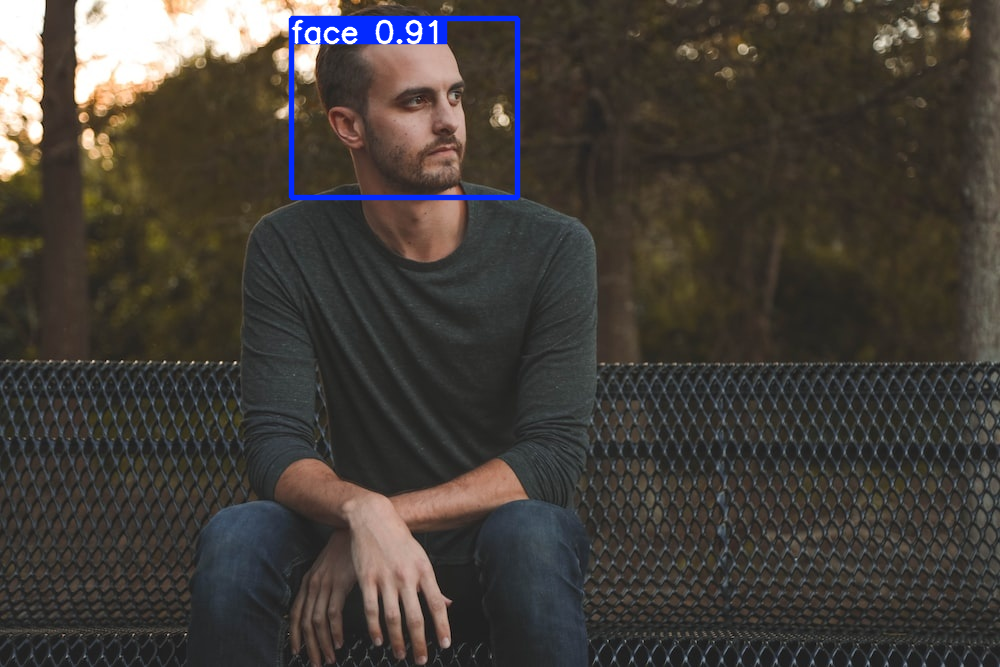

model yolov9 detection result on image '00000004.jpg'

image 1/1 /teamspace/studios/this_studio/images/00000020.jpg: 448x640 1 face, 102.6ms
Speed: 1.2ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


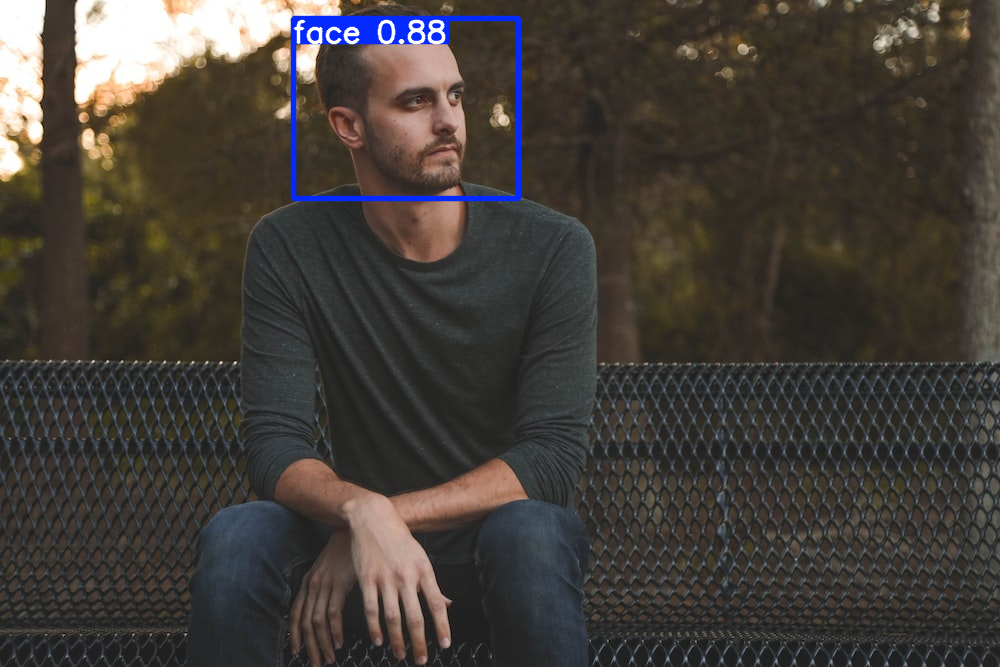

model yolov10 detection result on image '00000004.jpg'

image 1/1 /teamspace/studios/this_studio/images/00000020.jpg: 448x640 1 face, 33.7ms
Speed: 1.2ms preprocess, 33.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


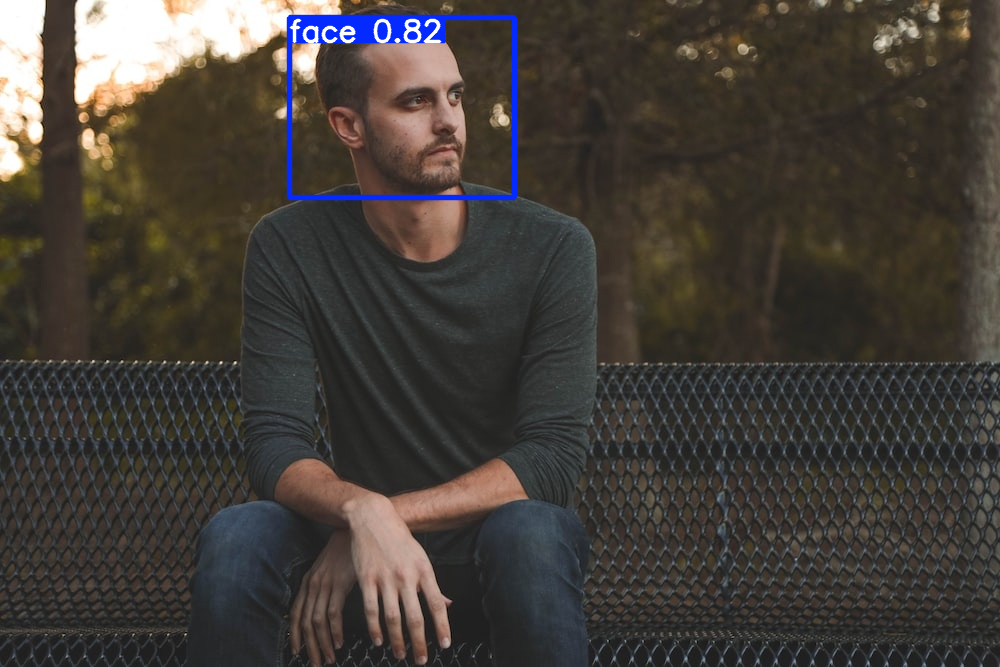

model yolov11 detection result on image '00000004.jpg'

image 1/1 /teamspace/studios/this_studio/images/00000020.jpg: 448x640 1 face, 48.5ms
Speed: 1.2ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


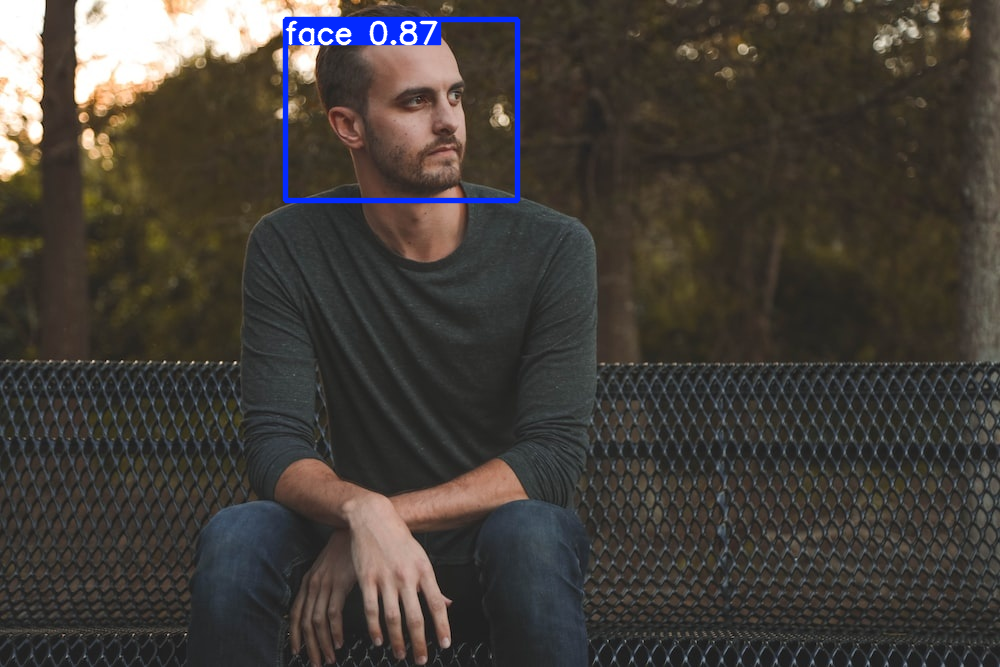

In [13]:
# Perform object detection on an image
for model_name in models_to_train:
    model = trained_models[model_name]['model']
    
    print(f"model {model_name} detection result on image '00000004.jpg'")
    
    # Perform object detection
    results = model("images/00000020.jpg", conf=0.8)
    
    # Filter results to keep only the box with the highest confidence
    if results[0].boxes:
        boxes = results[0].boxes
        max_conf_box = max(boxes, key=lambda box: box.conf)
        results[0].boxes = [max_conf_box]
    
    # Display the results
    results[0].show()
    
    # Save model weights
    save_dir = '/teamspace/studios/this_studio/trained_models'
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, f'{model_name}_model.pt')
    model.save(model_save_path)